In [173]:
# =========================
# 0) Install deps (Kaggle / Colab)
# =========================
# If you're on Kaggle, you can run this in a notebook cell.
!pip -q install opencv-python-headless scikit-learn mlxtend tqdm scikit-image kagglehub



In [174]:
# =========================
# 1) Imports + config
# =========================
import os, glob, random
import numpy as np
import cv2
from tqdm import tqdm

from sklearn.cluster import MiniBatchKMeans
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

from skimage.feature import local_binary_pattern


In [ ]:
# =========================
# 1b) Parameters
# =========================
# Dataset path (file or folder)
PATH_RAW = '/Users/dylesm/.cache/kagglehub/datasets/vesuvius13/formula-one-cars/versions/1/Formula One Cars/Ferrari F1 car/00000002.jpg'
DATA_EXTS = ('.jpg', '.jpeg', '.png', '.bmp', '.webp')

# Image preprocessing
IMG_SIZE = (256, 256)
MAX_IMAGES = 300
PATCH = 32
PATCHES_PER_IMAGE = 64

# Feature extraction
HSV_H_BINS = 8
HSV_S_BINS = 8
HSV_V_BINS = 8
LBP_P = 8
LBP_R = 1
LBP_METHOD = 'uniform'
LBP_BINS = LBP_P + 2

# Clustering
K = 100
KMEANS_BATCH_SIZE = 4096
KMEANS_RANDOM_STATE = 0

# Association rule mining
NEIGH = 2
MIN_SUPPORT = 0.005
MIN_CONF = 0.25
MERGE_ITERS = 3

# Output and visualization
OUT_DIR = './outputs_assocphrases'
FIG_SUBDIR = 'paper_figures'
WORD_LUT_SEED = 42
ALPHA = 0.45
N_SHOW_LIMIT = 12
N_VIZ_LIMIT = 30
N_CROP_VIZ_LIMIT = 80
N_OVERLAY_LIMIT = 30


In [175]:
# =========================
# 2) Point this at your Kaggle dataset images
# =========================
# Change this to your dataset root.


# Download latest version
# path = kagglehub.dataset_download("vesuvius13/formula-one-cars")
path = os.path.normpath(os.path.expanduser(PATH_RAW))

# If a file was provided, use its directory as the dataset root (handles spaces fine)
if os.path.isfile(path):
    path = os.path.dirname(path)

if not os.path.exists(path):
    raise FileNotFoundError(f"Path does not exist: {path}")

print("Path to dataset files:", path)

DATA_ROOT = path

# Common image extensions
def find_images(root):
    paths = []
    for dirpath, _, filenames in os.walk(root):
        for fn in filenames:
            if fn.lower().endswith(DATA_EXTS):
                paths.append(os.path.join(dirpath, fn))
    return paths

image_paths = find_images(DATA_ROOT)
print("Found images:", len(image_paths))
print("Example:", image_paths[:3])


Path to dataset files: /Users/dylesm/.cache/kagglehub/datasets/vesuvius13/formula-one-cars/versions/1/Formula One Cars/Ferrari F1 car
Found images: 365
Example: ['/Users/dylesm/.cache/kagglehub/datasets/vesuvius13/formula-one-cars/versions/1/Formula One Cars/Ferrari F1 car/00000428.jpg', '/Users/dylesm/.cache/kagglehub/datasets/vesuvius13/formula-one-cars/versions/1/Formula One Cars/Ferrari F1 car/00000366.jpg', '/Users/dylesm/.cache/kagglehub/datasets/vesuvius13/formula-one-cars/versions/1/Formula One Cars/Ferrari F1 car/00000414.jpg']


In [176]:
# =========================
# 3) Load + normalize images (resize)
# =========================

random.shuffle(image_paths)
image_paths_small = image_paths[:min(MAX_IMAGES, len(image_paths))]

def load_image_bgr(path, size=IMG_SIZE):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        return None
    img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    return img

imgs = []
kept_paths = []
for p in tqdm(image_paths_small):
    im = load_image_bgr(p)
    if im is not None:
        imgs.append(im)
        kept_paths.append(p)

print("Loaded:", len(imgs))


100%|██████████| 300/300 [00:06<00:00, 46.38it/s]

Loaded: 300


In [177]:
# =========================
# 4) Split into patches (per image)
# =========================
# With IMG_SIZE=256 and PATCH=32 => 8x8 grid

def image_to_patches(img_bgr, patch=PATCH):
    h, w = img_bgr.shape[:2]
    assert h % patch == 0 and w % patch == 0
    patches = []
    coords = []
    for y in range(0, h, patch):
        for x in range(0, w, patch):
            patches.append(img_bgr[y:y+patch, x:x+patch])
            coords.append((y // patch, x // patch))  # (row, col) in patch grid
    return patches, coords, (h // patch, w // patch)

# quick test
patches0, coords0, grid0 = image_to_patches(imgs[0])
print("Patches:", len(patches0), "Grid:", grid0)


Patches: 64 Grid: (8, 8)


In [178]:
# =========================
# 5) Patch feature extractor (simple + robust)
#    - Color histogram in HSV
#    - Texture via LBP histogram
# =========================
def hsv_hist(patch_bgr, h_bins=HSV_H_BINS, s_bins=HSV_S_BINS, v_bins=HSV_V_BINS):
    hsv = cv2.cvtColor(patch_bgr, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0,1,2], None, [h_bins,s_bins,v_bins], [0,180, 0,256, 0,256])
    hist = hist.flatten().astype(np.float32)
    hist /= (hist.sum() + 1e-8)
    return hist

def lbp_hist(patch_bgr):
    gray = cv2.cvtColor(patch_bgr, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, P=LBP_P, R=LBP_R, method=LBP_METHOD)
    # histogram over LBP codes
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, LBP_BINS+1), range=(0, LBP_BINS))
    hist = hist.astype(np.float32)
    hist /= (hist.sum() + 1e-8)
    return hist

def patch_features(patch_bgr):
    return np.concatenate([hsv_hist(patch_bgr), lbp_hist(patch_bgr)], axis=0)

# feature length check
feat0 = patch_features(patches0[0])
print("Feature dim:", feat0.shape)


Feature dim: (522,)


In [179]:
# =========================
# 6) Build a big feature matrix from many patches (for clustering)
# =========================
# To keep memory sane, subsample patches per image at first.
all_feats = []
all_meta = []  # (img_idx, patch_row, patch_col) for later mapping

for i, img in enumerate(tqdm(imgs)):
    patches, coords, (gh, gw) = image_to_patches(img)
    idxs = list(range(len(patches)))
    if len(idxs) > PATCHES_PER_IMAGE:
        idxs = random.sample(idxs, PATCHES_PER_IMAGE)

    for j in idxs:
        all_feats.append(patch_features(patches[j]))
        pr, pc = coords[j]
        all_meta.append((i, pr, pc))

X = np.vstack(all_feats)
print("Total patch samples:", X.shape)


100%|██████████| 300/300 [00:01<00:00, 165.53it/s]

Total patch samples: (19200, 522)


In [ ]:
# =========================
# 7) Quantize patches into "visual words" with k-means
# =========================
kmeans = MiniBatchKMeans(n_clusters=K, batch_size=KMEANS_BATCH_SIZE, random_state=KMEANS_RANDOM_STATE)
kmeans.fit(X)

print("Trained kmeans with K =", K)


Trained kmeans with K = 100


In [181]:
# =========================
# 8) Assign every patch in every image to a visual word
# =========================
def image_words_grid(img_bgr, patch=PATCH):
    patches, coords, (gh, gw) = image_to_patches(img_bgr, patch=patch)
    feats = np.vstack([patch_features(p) for p in patches])
    words = kmeans.predict(feats)  # [num_patches]
    grid = words.reshape(gh, gw)
    return grid  # shape: (gh, gw)

word_grids = []
for img in tqdm(imgs):
    word_grids.append(image_words_grid(img))

print("Example grid shape:", word_grids[0].shape)
print("Example grid IDs:\n", word_grids[0])


100%|██████████| 300/300 [00:02<00:00, 148.59it/s]

Example grid shape: (8, 8)
Example grid IDs:
 [[99 99 99 99 99 99 99  2]
 [99 69 99 99 99 99 99 52]
 [69 99 99 99  2  2  2 18]
 [99 99 99 51  2 51 14 52]
 [52 25 14 25 72 51 72 70]
 [52 25 72 33 70 33 70 70]
 [15 52 33 33 33 33 70 70]
 [27 48 27 27 27 27 27 27]]


In [182]:
# =========================
# 9) Build LOCAL transactions (3x3 neighborhoods)
#    Each transaction is a set of word IDs co-occurring locally.
# =========================
def local_transactions_from_grid(grid, neigh=NEIGH):
    gh, gw = grid.shape
    tx = []
    for r in range(gh):
        for c in range(gw):
            r0, r1 = max(0, r-neigh), min(gh, r+neigh+1)
            c0, c1 = max(0, c-neigh), min(gw, c+neigh+1)
            window = grid[r0:r1, c0:c1].ravel()
            # Use unique items so transaction is a set
            items = list(set(int(x) for x in window))
            # prefix items so TransactionEncoder treats them as categorical tokens
            items = [f"w{it}" for it in items]
            tx.append(items)
    return tx

transactions = []
for grid in tqdm(word_grids):
    transactions.extend(local_transactions_from_grid(grid))

print("Total transactions:", len(transactions))
print("Example transaction:", transactions[0][:2])


100%|██████████| 300/300 [00:00<00:00, 4987.20it/s]

Total transactions: 19200
Example transaction: ['w99', 'w69']


In [183]:
# =========================
# 10) Mine frequent itemsets + association rules
# =========================
# Start with modest thresholds; tune later.
te = TransactionEncoder()
T = te.fit(transactions).transform(transactions)
df = __import__("pandas").DataFrame(T, columns=te.columns_)

freq = apriori(df, min_support=MIN_SUPPORT, use_colnames=True)
rules = association_rules(freq, metric="confidence", min_threshold=MIN_CONF)

# Keep rules with reasonable lift too (optional but helpful)
rules = rules.sort_values(["confidence", "lift", "support"], ascending=False)

print("Frequent itemsets:", len(freq))
print("Rules:", len(rules))
rules.head(10)


Frequent itemsets: 548
Rules: 470


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
352,"(w27, w2)",(w48),0.008073,0.089167,0.006927,0.858065,9.623153,1.0,0.006207,6.417235,0.903377,0.076701,0.844170,0.467876
413,"(w52, w21)",(w51),0.007500,0.086563,0.006354,0.847222,9.787405,1.0,0.005705,5.978864,0.904612,0.072447,0.832744,0.460314
426,"(w27, w25)",(w48),0.007031,0.089167,0.005781,0.822222,9.221184,1.0,0.005154,5.123437,0.897867,0.063940,0.804819,0.443529
315,"(w21, w2)",(w51),0.010990,0.086563,0.008958,0.815166,9.417079,1.0,0.008007,4.941931,0.903742,0.101117,0.797650,0.459328
330,"(w4, w2)",(w24),0.007708,0.046198,0.006250,0.810811,17.550809,1.0,0.005894,5.041525,0.950348,0.131148,0.801647,0.473049
373,"(w49, w52)",(w2),0.009687,0.464948,0.007760,0.801075,1.722935,1.0,0.003256,2.689721,0.423700,0.016622,0.628214,0.408883
265,"(w14, w52)",(w2),0.046094,0.464948,0.036667,0.795480,1.710902,1.0,0.015235,2.616139,0.435591,0.077295,0.617757,0.437171
113,(w21),(w51),0.025052,0.086563,0.019635,0.783784,9.054542,1.0,0.017467,4.224648,0.912416,0.213477,0.763294,0.505309
283,"(w94, w14)",(w2),0.008542,0.464948,0.006615,0.774390,1.665542,1.0,0.002643,2.371582,0.403037,0.014168,0.578341,0.394308
13,(w43),(w12),0.007240,0.015469,0.005521,0.762590,49.298743,1.0,0.005409,4.146965,0.986860,0.321212,0.758860,0.559746


In [184]:
# =========================
# 11) Find "symmetric strong" pairs (A<->B), then merge candidates
#    For a first working version, only do pair rules (1 item -> 1 item)
# =========================
def is_singleton(fs):
    return isinstance(fs, (set, frozenset)) and len(fs) == 1

pair_rules = rules[
    rules["antecedents"].apply(is_singleton) &
    rules["consequents"].apply(is_singleton)
].copy()

# Build a lookup for confidence of (a -> b)
conf_map = {}
for _, row in pair_rules.iterrows():
    a = next(iter(row["antecedents"]))
    b = next(iter(row["consequents"]))
    conf_map[(a, b)] = float(row["confidence"])

# Symmetric candidates
sym = []
for (a, b), cab in conf_map.items():
    cba = conf_map.get((b, a), None)
    if cba is None:
        continue
    avg_conf = 0.5 * (cab + cba)
    sup = float(pair_rules[(pair_rules["antecedents"]==frozenset([a])) &
                           (pair_rules["consequents"]==frozenset([b]))]["support"].iloc[0])
    sym.append((avg_conf, sup, a, b))

sym.sort(reverse=True)
print("Symmetric strong pairs:", len(sym))
print("Top 10:")
for x in sym[:10]:
    print(x)


Symmetric strong pairs: 40
Top 10:
(0.5648015177869528, 0.0334375, 'w3', 'w10')
(0.5648015177869528, 0.0334375, 'w10', 'w3')
(0.5597461424799555, 0.005520833333333333, 'w43', 'w12')
(0.5597461424799555, 0.005520833333333333, 'w12', 'w43')
(0.49104359163312744, 0.03135416666666667, 'w22', 'w10')
(0.49104359163312744, 0.03135416666666667, 'w10', 'w22')
(0.4868299781712345, 0.010052083333333333, 'w73', 'w4')
(0.4868299781712345, 0.010052083333333333, 'w4', 'w73')
(0.48429771293766477, 0.15963541666666667, 'w52', 'w2')
(0.48429771293766477, 0.15963541666666667, 'w2', 'w52')


In [185]:
# =========================
# 12) (Starter) Apply ONE merge to see the mechanism work
#     Merge the best symmetric pair into a new token, e.g. p0 = {w12, w87}
# =========================
if len(sym) == 0:
    raise RuntimeError("No symmetric pairs found. Increase data, lower thresholds, or adjust patch/neighborhood/K.")

_, _, a, b = sym[0]
new_token = f"p0({a}+{b})"
print("Merging:", a, "<->", b, "into", new_token)

def apply_single_merge(transactions, a, b, new_token):
    out = []
    for tx in transactions:
        s = set(tx)
        if a in s and b in s:
            s.remove(a); s.remove(b)
            s.add(new_token)
        out.append(list(s))
    return out

transactions_merged = apply_single_merge(transactions, a, b, new_token)
print("Before:", transactions[0])
print("After :", transactions_merged[0])


Merging: w3 <-> w10 into p0(w3+w10)
Before: ['w99', 'w69']
After : ['w69', 'w99']


In [186]:
# =========================
# 13) (Next step) Wrap merging into an iterative loop (skeleton)
#     This is where you recreate the full paper-style iterative merging.
# =========================
def mine_pair_rules(transactions, min_support=0.005, min_conf=0.25):
    import pandas as pd
    te = TransactionEncoder()
    T = te.fit(transactions).transform(transactions)
    df = pd.DataFrame(T, columns=te.columns_)
    freq = apriori(df, min_support=min_support, use_colnames=True)
    rules = association_rules(freq, metric="confidence", min_threshold=min_conf)
    pair_rules = rules[
        rules["antecedents"].apply(is_singleton) &
        rules["consequents"].apply(is_singleton)
    ].copy()
    return pair_rules

def best_symmetric_pair(pair_rules):
    conf_map = {}
    for _, row in pair_rules.iterrows():
        a = next(iter(row["antecedents"]))
        b = next(iter(row["consequents"]))
        conf_map[(a, b)] = float(row["confidence"])
    best = None
    for (a, b), cab in conf_map.items():
        cba = conf_map.get((b, a))
        if cba is None:
            continue
        avg = 0.5 * (cab + cba)
        if (best is None) or (avg > best[0]):
            best = (avg, a, b)
    return best  # (avg_conf, a, b) or None

def iterative_merging(transactions, iters=5, min_support=0.005, min_conf=0.25):
    tx = transactions
    merges = []
    for t in range(iters):
        pair_rules = mine_pair_rules(tx, min_support=min_support, min_conf=min_conf)
        best = best_symmetric_pair(pair_rules)
        if best is None:
            print(f"Stop: no symmetric pair at iter {t}.")
            break
        avg_conf, a, b = best
        new_token = f"p{t}({a}+{b})"
        tx = apply_single_merge(tx, a, b, new_token)
        merges.append((new_token, a, b, avg_conf))
        print(f"Iter {t}: merge {a}<->{b} avg_conf={avg_conf:.3f} => {new_token}")
    return tx, merges

# Run a tiny number of merges to start
tx_final, merges = iterative_merging(transactions, iters=3, min_support=MIN_SUPPORT, min_conf=MIN_CONF)
print("Merges:", merges)


Iter 0: merge w3<->w10 avg_conf=0.565 => p0(w3+w10)
Iter 1: merge w43<->w12 avg_conf=0.560 => p1(w43+w12)
Iter 2: merge w73<->w4 avg_conf=0.487 => p2(w73+w4)
Merges: [('p0(w3+w10)', 'w3', 'w10', 0.5648015177869528), ('p1(w43+w12)', 'w43', 'w12', 0.5597461424799555), ('p2(w73+w4)', 'w73', 'w4', 0.4868299781712345)]


In [187]:
# =========================
# 14) Visualize + save results
#     - Save the visual-word grid (as a colored mosaic)
#     - Visualize where a merged "phrase" (pair a+b) fires
#     - Save example image crops around those hits
# =========================
import os
import numpy as np
import cv2

os.makedirs(OUT_DIR, exist_ok=True)

def ensure_dir(p):
    os.makedirs(p, exist_ok=True)
    return p

def save_bgr(path, img_bgr):
    cv2.imwrite(path, img_bgr)

def bgr_to_rgb(img_bgr):
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

def make_id_color_lut(n_ids, seed=0):
    rng = np.random.default_rng(seed)
    lut = rng.integers(0, 256, size=(n_ids, 3), dtype=np.uint8)
    lut[0] = np.array([0, 0, 0], dtype=np.uint8)
    return lut

# a fixed LUT so the same word ID always has the same color
WORD_LUT = make_id_color_lut(K, seed=WORD_LUT_SEED)


In [188]:
# =========================
# 15) Save a "visual word mosaic" for a few images
#     Each patch becomes a solid color based on its word ID
# =========================
def word_grid_to_mosaic(grid, patch=PATCH, lut=WORD_LUT):
    # grid shape: (gh, gw)
    gh, gw = grid.shape
    color_grid = lut[grid.astype(np.int32)]  # (gh, gw, 3) in RGB-ish but we treat as BGR for saving
    # expand each cell to patch x patch
    mosaic = np.repeat(np.repeat(color_grid, patch, axis=0), patch, axis=1)
    return mosaic  # BGR-like; doesn't matter as it's pseudo-color

mosaic_dir = ensure_dir(os.path.join(OUT_DIR, "word_mosaics"))

N_SHOW = min(N_SHOW_LIMIT, len(imgs))
for i in range(N_SHOW):
    grid = word_grids[i]
    mosaic = word_grid_to_mosaic(grid, patch=PATCH, lut=WORD_LUT)
    out_path = os.path.join(mosaic_dir, f"img_{i:04d}_word_mosaic.png")
    save_bgr(out_path, mosaic)

print("Saved mosaics to:", mosaic_dir)


Saved mosaics to: ./outputs_assocphrases/word_mosaics


In [189]:
# =========================
# 16) Phrase-hit heatmap for a merged pair (a,b)
#     If a & b occur together inside the local neighborhood of a cell,
#     mark that cell as a "hit".
# =========================
def phrase_hit_map(grid, a_token, b_token, neigh=NEIGH):
    """
    grid: (gh, gw) of int word IDs
    a_token, b_token: like "w12" strings
    returns: hit map (gh, gw) boolean
    """
    a_id = int(a_token[1:])  # "w12" -> 12
    b_id = int(b_token[1:])
    gh, gw = grid.shape
    hit = np.zeros((gh, gw), dtype=bool)

    for r in range(gh):
        for c in range(gw):
            r0, r1 = max(0, r-neigh), min(gh, r+neigh+1)
            c0, c1 = max(0, c-neigh), min(gw, c+neigh+1)
            window = grid[r0:r1, c0:c1]
            has_a = np.any(window == a_id)
            has_b = np.any(window == b_id)
            hit[r, c] = bool(has_a and has_b)
    return hit

def overlay_hits_on_image(img_bgr, hit_map, patch=PATCH, alpha=0.35):
    """
    img_bgr: (H,W,3)
    hit_map: (gh,gw) boolean; aligns with patch grid
    """
    H, W = img_bgr.shape[:2]
    gh, gw = hit_map.shape
    assert H == gh * patch and W == gw * patch

    overlay = img_bgr.copy()
    # make a per-pixel mask by expanding hit_map
    mask = np.repeat(np.repeat(hit_map.astype(np.uint8), patch, axis=0), patch, axis=1)
    mask = mask[:H, :W]

    # color for hits (BGR)
    hit_color = np.array([0, 0, 255], dtype=np.uint8)  # red in BGR

    overlay[mask == 1] = (overlay[mask == 1].astype(np.float32) * (1 - alpha) +
                          hit_color.astype(np.float32) * alpha).astype(np.uint8)
    return overlay

# Use the top symmetric pair you found earlier:
# variables a, b were set when you merged p0. If not, pick from sym list.
a_token, b_token = a, b
print("Visualizing phrase pair:", a_token, b_token)


Visualizing phrase pair: w3 w10


In [190]:
# =========================
# 17) Save overlays + heatmaps for a subset of images
# =========================
phrase_dir = ensure_dir(os.path.join(OUT_DIR, "phrase_overlays"))

def save_heatmap_png(hit_map, out_path, scale=40):
    # Simple black/white heatmap (hit=white)
    hm = (hit_map.astype(np.uint8) * 255)
    hm = cv2.resize(hm, (hit_map.shape[1]*scale, hit_map.shape[0]*scale), interpolation=cv2.INTER_NEAREST)
    hm_bgr = cv2.cvtColor(hm, cv2.COLOR_GRAY2BGR)
    save_bgr(out_path, hm_bgr)

N_VIZ = min(N_VIZ_LIMIT, len(imgs))
saved = 0
for i in range(N_VIZ):
    grid = word_grids[i]
    hit = phrase_hit_map(grid, a_token, b_token, neigh=NEIGH)
    if hit.sum() == 0:
        continue

    overlay = overlay_hits_on_image(imgs[i], hit, patch=PATCH, alpha=0.40)
    out_overlay = os.path.join(phrase_dir, f"img_{i:04d}_overlay_{a_token}_{b_token}.png")
    out_heatmap = os.path.join(phrase_dir, f"img_{i:04d}_heatmap_{a_token}_{b_token}.png")

    save_bgr(out_overlay, overlay)
    save_heatmap_png(hit, out_heatmap, scale=40)
    saved += 1

print(f"Saved {saved} overlays/heatmaps to:", phrase_dir)


Saved 7 overlays/heatmaps to: ./outputs_assocphrases/phrase_overlays


In [191]:
# =========================
# 18) Save example crops around hits (so you can inspect what the phrase "means")
# =========================
crops_dir = ensure_dir(os.path.join(OUT_DIR, "phrase_crops"))

def extract_hit_crops(img_bgr, hit_map, patch=PATCH, crop_radius_patches=2, max_crops=8):
    """
    For each hit cell, take a crop centered on that cell with radius in patches.
    """
    H, W = img_bgr.shape[:2]
    gh, gw = hit_map.shape
    crops = []
    hit_positions = np.argwhere(hit_map)

    if len(hit_positions) == 0:
        return crops

    # sample a few hit positions so we don't dump thousands
    rng = np.random.default_rng(0)
    if len(hit_positions) > max_crops:
        hit_positions = hit_positions[rng.choice(len(hit_positions), size=max_crops, replace=False)]

    for (r, c) in hit_positions:
        cy = r * patch + patch // 2
        cx = c * patch + patch // 2
        half = crop_radius_patches * patch

        y0, y1 = max(0, cy - half), min(H, cy + half)
        x0, x1 = max(0, cx - half), min(W, cx + half)
        crop = img_bgr[y0:y1, x0:x1].copy()
        crops.append(((r, c), crop))
    return crops

N_CROP_VIZ = min(N_CROP_VIZ_LIMIT, len(imgs))
crop_saved = 0
for i in range(N_CROP_VIZ):
    grid = word_grids[i]
    hit = phrase_hit_map(grid, a_token, b_token, neigh=NEIGH)
    if hit.sum() == 0:
        continue

    crops = extract_hit_crops(imgs[i], hit, patch=PATCH, crop_radius_patches=2, max_crops=10)
    for (r, c), crop in crops:
        out_path = os.path.join(crops_dir, f"img_{i:04d}_hit_r{r}_c{c}_{a_token}_{b_token}.png")
        save_bgr(out_path, crop)
        crop_saved += 1

print(f"Saved {crop_saved} crops to:", crops_dir)


Saved 76 crops to: ./outputs_assocphrases/phrase_crops


In [192]:
# =========================
# 20) Transparent word-mosaic overlay
# =========================
def overlay_word_mosaic(
    img_bgr,
    word_grid,
    patch=PATCH,
    lut=WORD_LUT,
    alpha=0.45
):
    """
    img_bgr   : (H,W,3) uint8
    word_grid : (gh,gw) int word IDs
    alpha     : transparency of mosaic overlay
    """
    H, W = img_bgr.shape[:2]
    gh, gw = word_grid.shape
    assert H == gh * patch and W == gw * patch

    # build colored mosaic
    color_grid = lut[word_grid.astype(np.int32)]  # (gh,gw,3)
    mosaic = np.repeat(np.repeat(color_grid, patch, axis=0), patch, axis=1)

    mosaic = mosaic[:H, :W].astype(np.float32)
    img_f = img_bgr.astype(np.float32)

    blended = (1 - alpha) * img_f + alpha * mosaic
    return blended.astype(np.uint8)


In [193]:
# =========================
# 21) Save word-mosaic overlays on original images
# =========================
overlay_dir = ensure_dir(os.path.join(OUT_DIR, "word_overlay"))

N_OVERLAY = min(N_OVERLAY_LIMIT, len(imgs))

for i in range(N_OVERLAY):
    img = imgs[i]
    grid = word_grids[i]

    overlay = overlay_word_mosaic(
        img_bgr=img,
        word_grid=grid,
        patch=PATCH,
        lut=WORD_LUT,
        alpha=ALPHA
    )

    out_path = os.path.join(overlay_dir, f"img_{i:04d}_word_overlay.png")
    save_bgr(out_path, overlay)

print("Saved word overlays to:", overlay_dir)


Saved word overlays to: ./outputs_assocphrases/word_overlay


In [194]:
# =========================
# 22) Side-by-side: original | overlay
# =========================
compare_dir = ensure_dir(os.path.join(OUT_DIR, "word_overlay_compare"))

for i in range(N_OVERLAY):
    img = imgs[i]
    grid = word_grids[i]

    overlay = overlay_word_mosaic(img, grid, PATCH, WORD_LUT, alpha=ALPHA)
    combined = np.hstack([img, overlay])

    out_path = os.path.join(compare_dir, f"img_{i:04d}_compare.png")
    save_bgr(out_path, combined)

print("Saved comparisons to:", compare_dir)


Saved comparisons to: ./outputs_assocphrases/word_overlay_compare


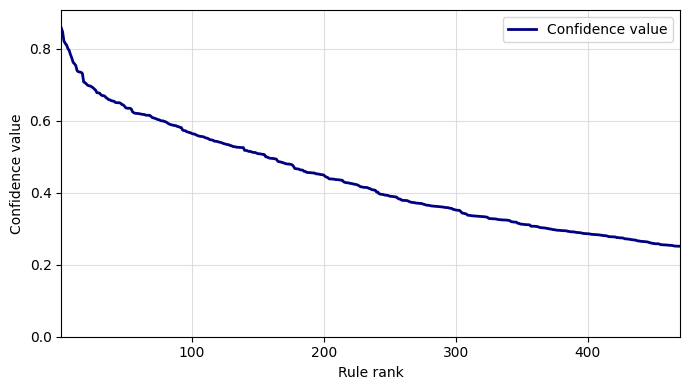

Iter 0: merge w3<->w10 avg_conf=0.565 => p0(w3+w10)
Iter 1: merge w43<->w12 avg_conf=0.560 => p1(w43+w12)
Iter 2: merge w73<->w4 avg_conf=0.487 => p2(w73+w4)


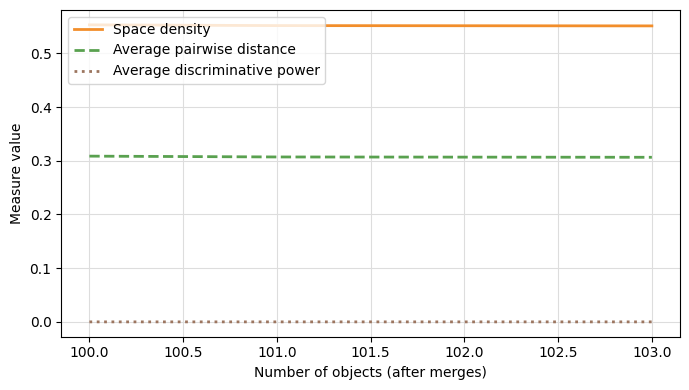

In [196]:
# =========================
# 23) Figures 3 and 4 (data-driven)
# =========================
import os
import numpy as np
import matplotlib.pyplot as plt

FIG_DIR = os.path.join(OUT_DIR, FIG_SUBDIR)
os.makedirs(FIG_DIR, exist_ok=True)

# ---- Helpers for data-driven figures ----
def build_transactions_per_image(word_grids, neigh):
    return [local_transactions_from_grid(grid, neigh=neigh) for grid in word_grids]

def flatten_transactions(tx_per_image):
    out = []
    for tx in tx_per_image:
        out.extend(tx)
    return out

def mine_rules_from_transactions(transactions, min_support, min_conf):
    import pandas as pd
    te = TransactionEncoder()
    T = te.fit(transactions).transform(transactions)
    df = pd.DataFrame(T, columns=te.columns_)
    freq = apriori(df, min_support=min_support, use_colnames=True)
    rules_local = association_rules(freq, metric='confidence', min_threshold=min_conf)
    rules_local = rules_local.sort_values(['confidence', 'lift', 'support'], ascending=False)
    return rules_local

def doc_sets_from_transactions(tx_per_image):
    doc_sets = []
    for tx in tx_per_image:
        s = set()
        for items in tx:
            s.update(items)
        doc_sets.append(s)
    return doc_sets

def density_from_matrix(X):
    eps = 1e-12
    norms = np.linalg.norm(X, axis=1) + eps
    Xn = X / norms[:, None]
    centroid = X.mean(axis=0)
    c_norm = np.linalg.norm(centroid) + eps
    sims = (Xn @ centroid) / c_norm
    return float(np.mean(sims))

def avg_pairwise_similarity(X):
    eps = 1e-12
    norms = np.linalg.norm(X, axis=1) + eps
    Xn = X / norms[:, None]
    sim = Xn @ Xn.T
    n = sim.shape[0]
    k = n * (n + 1) / 2.0
    total = (np.sum(sim) + np.sum(np.diag(sim))) / 2.0
    return float(total / k)

def compute_metrics(doc_sets):
    vocab = sorted(set().union(*doc_sets))
    if len(vocab) == 0:
        return 0, 0, 0, 0
    idx = {t: i for i, t in enumerate(vocab)}
    X = np.zeros((len(doc_sets), len(vocab)), dtype=np.float32)
    for i, s in enumerate(doc_sets):
        for t in s:
            X[i, idx[t]] = 1.0

    density = density_from_matrix(X)
    avg_pair = avg_pairwise_similarity(X)

    if X.shape[1] == 0:
        avg_disc = 0.0
    else:
        diffs = []
        for col in range(X.shape[1]):
            X2 = X.copy()
            X2[:, col] = 0.0
            d_wo = density_from_matrix(X2)
            diffs.append(density - d_wo)
        avg_disc = float(np.mean(diffs))

    return density, avg_pair, avg_disc, len(vocab)

def apply_merge_to_tx_per_image(tx_per_image, a, b, new_token):
    out = []
    for tx in tx_per_image:
        out_tx = []
        for items in tx:
            s = set(items)
            if a in s and b in s:
                s.remove(a); s.remove(b)
                s.add(new_token)
            out_tx.append(list(s))
        out.append(out_tx)
    return out

def iterative_merging_with_metrics(tx_per_image, iters, min_support, min_conf):
    curves = []
    current = tx_per_image
    for t in range(iters + 1):
        doc_sets = doc_sets_from_transactions(current)
        density, avg_pair, avg_disc, n_obj = compute_metrics(doc_sets)
        curves.append((n_obj, density, avg_pair, avg_disc))
        if t == iters:
            break
        tx_all = flatten_transactions(current)
        pair_rules = mine_pair_rules(tx_all, min_support=min_support, min_conf=min_conf)
        best = best_symmetric_pair(pair_rules)
        if best is None:
            print(f'Stop: no symmetric pair at iter {t}.')
            break
        avg_conf, a, b = best
        new_token = f'p{t}({a}+{b})'
        current = apply_merge_to_tx_per_image(current, a, b, new_token)
        print(f'Iter {t}: merge {a}<->{b} avg_conf={avg_conf:.3f} => {new_token}')
    return curves

# ---- Fig. 3: confidence values (real data) ----
if 'rules' in globals():
    rules_for_fig3 = rules
else:
    rules_for_fig3 = mine_rules_from_transactions(transactions, MIN_SUPPORT, MIN_CONF)

conf_vals = rules_for_fig3['confidence'].sort_values(ascending=False).values
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(np.arange(1, len(conf_vals) + 1), conf_vals, color='navy', lw=2)
ax.set_xlim(1, max(1, len(conf_vals)))
ax.set_ylim(0, min(1.05, max(0.2, conf_vals.max() + 0.05)))
ax.set_xlabel('Rule rank')
ax.set_ylabel('Confidence value')
ax.grid(True, color='#dddddd', linewidth=0.8)
ax.legend(['Confidence value'], loc='upper right')
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR, 'fig3_confidence_values.png'), dpi=200)
plt.show()

# ---- Fig. 4: curves for density, distance, discriminative power (real data) ----
tx_per_image = build_transactions_per_image(word_grids, neigh=NEIGH)
curves = iterative_merging_with_metrics(tx_per_image, iters=MERGE_ITERS, min_support=MIN_SUPPORT, min_conf=MIN_CONF)
if len(curves) >= 2:
    curves = np.array(curves)
    n_obj = curves[:, 0]
    density = curves[:, 1]
    avg_pair = curves[:, 2]
    avg_disc = curves[:, 3]

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(n_obj, density, color='#f28e2b', lw=2, label='Space density')
    ax.plot(n_obj, avg_pair, color='#59a14f', lw=2, ls='--', label='Average pairwise distance')
    ax.plot(n_obj, avg_disc, color='#9c755f', lw=2, ls=':', label='Average discriminative power')
    ax.set_xlabel('Number of objects (after merges)')
    ax.set_ylabel('Measure value')
    ax.grid(True, color='#dddddd', linewidth=0.8)
    ax.legend(loc='upper left')
    fig.tight_layout()
    fig.savefig(os.path.join(FIG_DIR, 'fig4_curves_measures.png'), dpi=200)
    plt.show()
else:
    print('Fig. 4 skipped (not enough merges or data).')
